<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C3W3_7_Overfitting_in_NLP_Transfer_Learning_GloVe_Twitter_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []

In [0]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-04-27 21:10:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  93.1MB/s    in 2.4s    

2020-04-27 21:10:08 (93.1 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



**Context**  
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

**Content**  
It contains the following 6 fields:

*   **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
*   **ids**: The id of the tweet ( 2087)
*   **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
*   **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
*   **user**: the user that tweeted (robotickilldozr)
*   **text**: the text of the tweet (Lyx is cool)

In [0]:
num_sentences = 0
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
      list_item=['','']
        # YOUR CODE HERE
      list_item[0] = row[0]
      list_item[1] = row[5]
      num_sentences = num_sentences + 1
      corpus.append(list_item)

In [0]:
print(num_sentences)
print(len(corpus))

print(corpus[20])
print(corpus[21])
print(corpus[22])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
['0', "@alydesigns i was out most of the day so didn't get much done "]
['0', "one of my friend called me, and asked to meet with her at Mid Valley today...but i've no time *sigh* "]
['0', '@angry_barista I baked you a cake but I ated it ']


In [0]:
corpus[:3]

[['0',
  "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"],
 ['0',
  "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"],
 ['0',
  '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']]

In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    #print(corpus[x])
    sentences.append(corpus[x][1])
    label = 1
    if corpus[x][0] == '0':
      label = 0
    labels.append(label)

tokenizer = Tokenizer() #num_words = vocab_size, oov_token=oov_tok
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = np.asarray(padded[:split])
training_sequences = np.asarray(padded[split:training_size])
test_labels = np.asarray(labels[:split])
training_labels = np.asarray(labels[split:training_size])

In [0]:
set(labels)

{0, 1}

In [0]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

139105
1


# Word embedding from Tokenizer()

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13910600  
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 13,913,049
Trainable params: 13,913,049
Non-trainable params: 0
_________________________________________________________________


In [0]:
num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

Epoch 1/10
4500/4500 [==============================] - 598s 133ms/step - loss: 0.4954 - accuracy: 0.7586 - val_loss: 0.4669 - val_accuracy: 0.7730
Epoch 2/10
4500/4500 [==============================] - 597s 133ms/step - loss: 0.3861 - accuracy: 0.8243 - val_loss: 0.4835 - val_accuracy: 0.7714
Epoch 3/10
4500/4500 [==============================] - 594s 132ms/step - loss: 0.2998 - accuracy: 0.8710 - val_loss: 0.5447 - val_accuracy: 0.7599
Epoch 4/10
4500/4500 [==============================] - 587s 130ms/step - loss: 0.2275 - accuracy: 0.9061 - val_loss: 0.6131 - val_accuracy: 0.7520
Epoch 5/10
4500/4500 [==============================] - 580s 129ms/step - loss: 0.1805 - accuracy: 0.9273 - val_loss: 0.6722 - val_accuracy: 0.7439
Epoch 6/10
4500/4500 [==============================] - 573s 127ms/step - loss: 0.1503 - accuracy: 0.9404 - val_loss: 0.7579 - val_accuracy: 0.7358
Epoch 7/10
4500/4500 [==============================] - 572s 127ms/step - loss: 0.1298 - accuracy: 0.9492 - val_

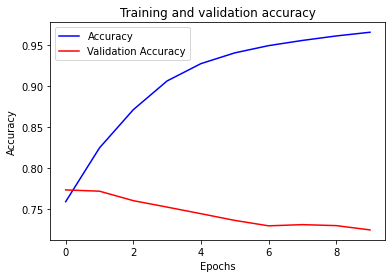

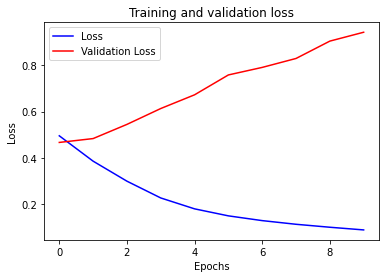

<Figure size 432x288 with 0 Axes>

In [0]:
plot_accuracy_loss(history)

In [0]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-04-23 22:18:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  50.8MB/s    in 6.5s    

2020-04-23 22:18:32 (50.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [0]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [0]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138705


In [0]:
len(set(training_labels))

2

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(len(acc)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation accuracy per epoch
  #------------------------------------------------
  plt.plot(epochs, acc, 'b')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])

  plt.figure();

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'b')
  plt.plot(epochs, val_loss, 'r')
  plt.title('Training and validation loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])

  plt.figure();


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Word embedding from GloVe - Transfer Learning
https://nlp.stanford.edu/projects/glove/

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
global_average_pooling1d_13  (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 24)                2424      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 25        
Total params: 13,872,949
Trainable params: 2,449
Non-trainable params: 13,870,500
_________________________________________________________________


In [0]:
num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

Epoch 1/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.6051 - accuracy: 0.6765 - val_loss: 0.5800 - val_accuracy: 0.6911
Epoch 2/10
4500/4500 [==============================] - 10s 2ms/step - loss: 0.5812 - accuracy: 0.6928 - val_loss: 0.5715 - val_accuracy: 0.6994
Epoch 3/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.5742 - accuracy: 0.6974 - val_loss: 0.5685 - val_accuracy: 0.7034
Epoch 4/10
4500/4500 [==============================] - 10s 2ms/step - loss: 0.5691 - accuracy: 0.7019 - val_loss: 0.5624 - val_accuracy: 0.7084
Epoch 5/10
4500/4500 [==============================] - 10s 2ms/step - loss: 0.5653 - accuracy: 0.7040 - val_loss: 0.5650 - val_accuracy: 0.7047
Epoch 6/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.5628 - accuracy: 0.7083 - val_loss: 0.5624 - val_accuracy: 0.7122
Epoch 7/10
4500/4500 [==============================] - 11s 2ms/step - loss: 0.5606 - accuracy: 0.7082 - val_loss: 0.5582 - val_ac

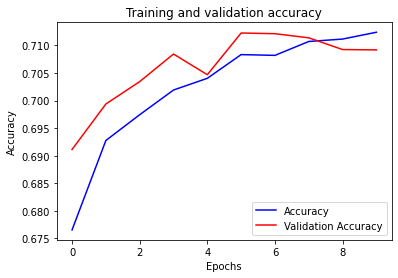

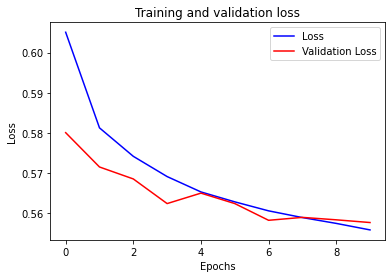

<Figure size 432x288 with 0 Axes>

In [0]:
plot_accuracy_loss(history)

# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_34 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 25        
Total params: 13,958,101
Trainable params: 87,601
Non-trainable params: 13,870,500
_________________________________________________________________
Epoch 1/10
4500/4500 [==============================] - 27s 6ms/step - loss: 0.5338 - accuracy: 0.7270 - val_loss: 0.4979 - val_accuracy: 0.7503
Epoch 2/10
4500/4500 [==============================] - 26s 6ms/step - loss: 0.4853 - acc

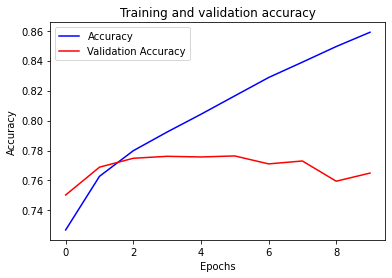

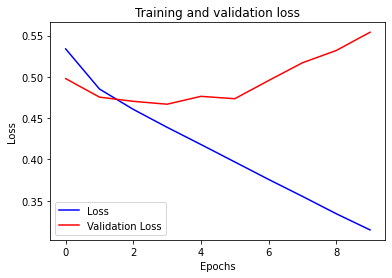

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)

# WINNER 78% validation accuracy!
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
# tf.keras.layers.Dropout(0.2),

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 25        
Total params: 13,997,781
Trainable params: 127,281
Non-trainable params: 13,870,500
___________________________________

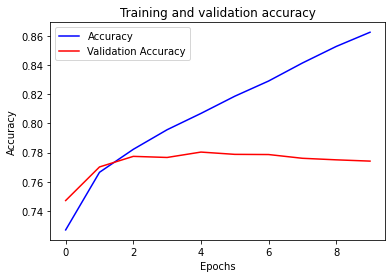

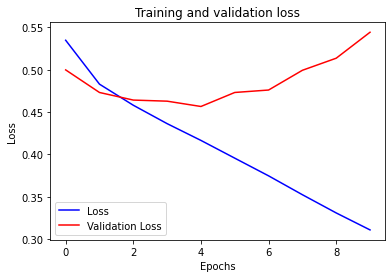

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)

# tf.keras.layers.Conv1D(128, 5, activation='relu'),
# tf.keras.layers.GlobalAveragePooling1D(),
# tf.keras.layers.Dropout(0.2),

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
global_average_pooling1d_14  (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 25        
Total params: 13,937,749
Trainable params: 67,249
Non-trainable params: 13,870,500
____________________________________

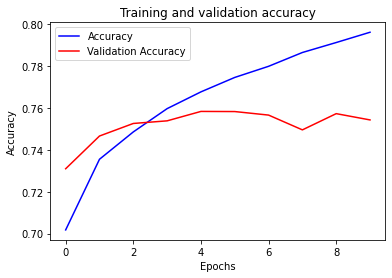

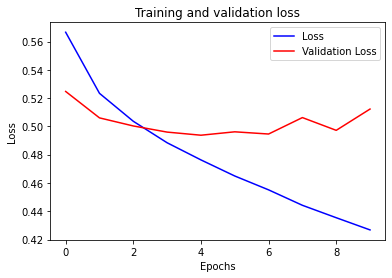

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)

# tf.keras.layers.Conv1D(128, 5, activation='relu'),
# tf.keras.layers.Conv1D(128, 3, activation='relu'),
# tf.keras.layers.GlobalAveragePooling1D(),
# tf.keras.layers.Dropout(0.2),

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 128)           49280     
_________________________________________________________________
global_average_pooling1d_15  (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 24)                3096      
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

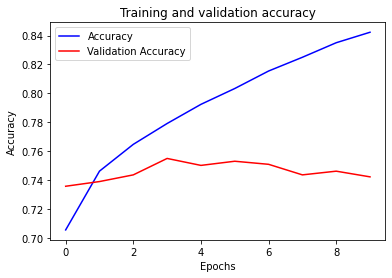

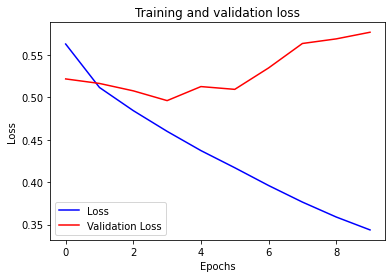

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)

# tf.keras.layers.Dropout(0.2),
# tf.keras.layers.Conv1D(64, 5, activation='relu'),
# tf.keras.layers.MaxPooling1D(pool_size=4),
# tf.keras.layers.LSTM(64),

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 65        
Total params: 13,935,653
Trainable params: 65,153
Non-trainable params: 13,870,500
____________________________________

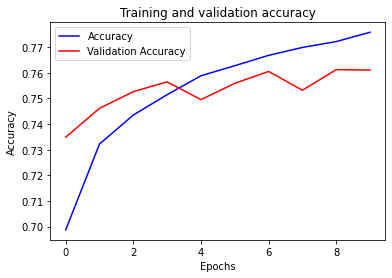

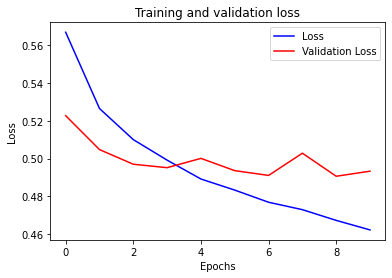

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)

# tf.keras.layers.Dropout(0.2),
# tf.keras.layers.Conv1D(64, 5, activation='relu'),
# tf.keras.layers.MaxPooling1D(pool_size=4),  
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 16, 100)           13870500  
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 100)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 3, 128)            66048     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

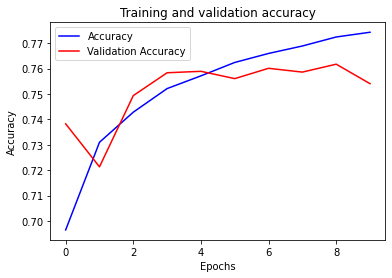

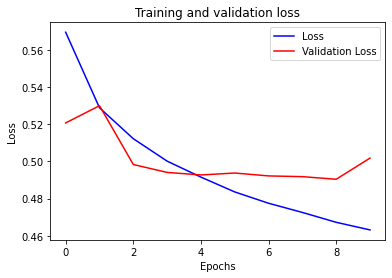

<Figure size 432x288 with 0 Axes>

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels))

plot_accuracy_loss(history)